<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/Twitter%20US%20Airline%20Sentiment%20-%20NLP%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- Kaggle Twitter US Airline Sentiment
  - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [1]:
# mount gdrive, required for downloaded dataset
import os
from google.colab import drive
drive.mount("/content/drive")

!mkdir -p /content/drive/MyDrive/Neural\ Networks
!mkdir -p /content/drive/MyDrive/Neural\ Networks/Twitter\ US\ Airline\ Sentiment
!mkdir -p /content/drive/MyDrive/Neural\ Networks/Twitter\ US\ Airline\ Sentiment/data

# URL for our dataset, Tweets.csv
URL = "https://drive.google.com/file/d/15XHy_PdD6Q2aa6n-pnWmSFGCv1oK9vWA/view?usp=sharing"
DOWNLOAD_FILE_PATH = "https://drive.google.com/uc?export=download&id=" + URL.split("/")[-2]

# install gdown, required for download file from GDrive
!pip -q install gdown==4.6.0
import gdown
gdown.download(DOWNLOAD_FILE_PATH, "/content/drive/MyDrive/Neural Networks/Twitter US Airline Sentiment/data/Tweets.csv", quiet=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Neural Networks/Twitter US Airline Sentiment/data/Tweets.csv'

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout, TextVectorization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 204

tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

FILE_PATH = "/content/drive/MyDrive/Neural Networks/Twitter US Airline Sentiment/data/Tweets.csv"

In [3]:
tweets = pd.read_csv(FILE_PATH, sep=',')
tweets = tweets[['text', 'airline_sentiment']]

tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
TEST_SIZE = 0.2

(tweets_train, tweets_test,
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['airline_sentiment'],
                                                     test_size=TEST_SIZE, stratify=tweets['airline_sentiment'],
                                                     shuffle=True, random_state=SEED)

In [5]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['airline_sentiment'])

y_train = to_categorical(label_encoder.transform(sentiment_train))
y_test = to_categorical(label_encoder.transform(sentiment_test))

In [7]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [8]:
counts = tweets.groupby(['airline_sentiment']).count()
counts.reset_index(inplace=True)

counts

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


In [9]:
naive_baseline = counts[counts['airline_sentiment']=='negative']['text'].values[0] / counts['text'].sum()

naive_baseline

0.6269125683060109

In [10]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 0.531686943889595, 1: 1.5750403442711136, 2: 2.0648801128349787}

In [11]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy',
           F1Score(name='f1_score', average='macro'),
           AUC(name='auc', multi_label=True)]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [15]:
baseline = Sequential(
    [
        Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
    ],
    name="baseline"
)

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 15003     
                                                                 
Total params: 15003 (58.61 KB)
Trainable params: 15003 (58.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
learning_rate = 0.01
batch_size = 512

EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [18]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [19]:
baseline_history = baseline.fit(X_train, y_train,
                                class_weight=CLASS_WEIGHT,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [20]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(baseline_scores[1]))
print('AUC (Validation): {:.2f}'.format(baseline_scores[2]))

Accuracy (Validation): 0.78 (Naive Baseline=0.63)
F1 Score (Validation): 0.73
AUC (Validation): 0.90


In [21]:
preds = baseline.predict(X_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline = {:.2f})'.format(balanced_accuracy_score(y_val.argmax(axis=1), preds), naive_baseline))

Balanced Accuracy (Validation): 0.74 (baseline = 0.63)


In [22]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

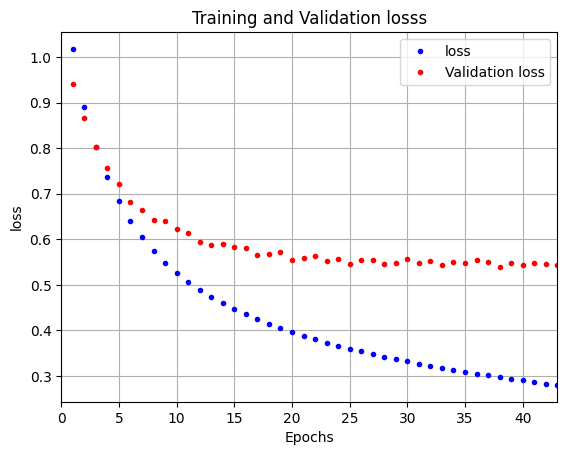

In [25]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [31]:
overfit = Sequential(
    [
        Dense(64, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden"),
        Dense(OUTPUT_CLASSES, activation="softmax", name="output")
    ],
    name="overfit"
)

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 64)                320064    
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 320259 (1.22 MB)
Trainable params: 320259 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
learning_rate = 0.0025

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

In [33]:
EPOCHS = 100
batch_size=512

overfit_history = overfit.fit(X_train, y_train,
                              class_weight=CLASS_WEIGHT,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [34]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(overfit_scores[1]))
print('AUC (Validation): {:.2f}'.format(overfit_scores[2]))

Accuracy (Validation): 0.75 (Naive Baseline = 0.63)
F1 Score (Validation): 0.67
AUC (Validation): 0.84


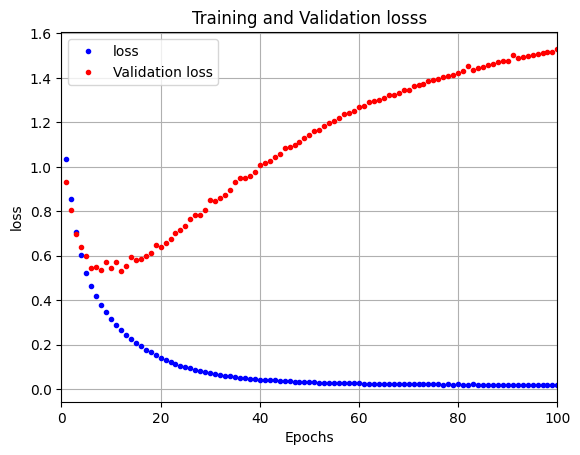

In [35]:
plot_training_history(overfit_history, monitor='loss')

 ## Regularizing your model and tuning your hyperparameters

In [126]:
# over-sized model - neural network architecture that can overfit the data
deep = Sequential(
    [
        Dense(64,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(INPUT_DIMENSION,), name='hidden'),
        Dropout(rate=0.5),
        Dense(OUTPUT_CLASSES,  activation='softmax', name='output')
    ],
    name="deep"
)

deep.summary()

Model: "deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 64)                320064    
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 320259 (1.22 MB)
Trainable params: 320259 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
wider = Sequential(
    [
        Dense(128,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(INPUT_DIMENSION,), name='hidden'),
        Dropout(0.5),
        Dense(OUTPUT_CLASSES,  activation='softmax', name='ouput')
    ]
)

wider._name = 'wider'

wider.summary()

Model: "wider"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 128)               640128    
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 ouput_layer (Dense)         (None, 3)                 387       
                                                                 
Total params: 640515 (2.44 MB)
Trainable params: 640515 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
deeper = Sequential(
    [
        Dense(64,  kernel_regularizer=l2(0.0), activation='relu', input_shape=(INPUT_DIMENSION,), name='hidden.0'),
        Dropout(rate=0.5),
        Dense(64,  kernel_regularizer=l2(0.0), activation='relu', name='hidden.1'),
        Dropout(rate=0.5),
        Dense(OUTPUT_CLASSES,  activation='softmax', name='output')
    ]
)

deeper._name = 'deeper'

deeper.summary()

Model: "deeper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden_ayer (Dense)     (None, 64)                320064    
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 2nd_hidden_layer (Dense)    (None, 64)                4160      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 324419 (1.24 MB)
Trainable params: 324419 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
for layer in deep.layers :
    print(type(layer))

<class 'keras.src.layers.core.dense.Dense'>
<class 'keras.src.layers.regularization.dropout.Dropout'>
<class 'keras.src.layers.core.dense.Dense'>


In [105]:
layer._name

'dense_21'

In [140]:
def cross_validation(X, y,
                     class_weight,
                     params, kfolds, epochs,
                     callbacks, seed=0) :
    evaluations = []
    for train, validate in kfolds.split(X, y.argmax(axis=1)) :
        model = clone_model(params['model'])

        for layer in model.layers :
            if type(layer) == keras.src.layers.regularization.dropout.Dropout :
                layer.rate = params['dropout']

            if type(layer) == keras.src.layers.core.dense.Dense :
                 if (layer.activation != 'softmax') or (layer._name != 'output') :
                    layer.kernel_regularizer = l2(params['alpha'])

        model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']),
                      loss=LOSS_FUNC, metrics=METRICS)

        history = model.fit(X[train,:], y[train,:],
                            class_weight=class_weight,
                            batch_size=params['batch_size'], epochs=epochs,
                            validation_data=(X[validate,:], y[validate,:]),
                            callbacks=callbacks,
                            verbose=0)

        evaluation = model.evaluate(X_val, y_val, verbose=0)[1:]
        evaluations.append( evaluation )

    return np.mean(evaluations, axis=0)

In [141]:
def grid_search_cv(X, y,
                   class_weight,
                   search_space, cv,
                   epochs, callbacks=[], seed=0) :

    keys, values = zip(*search_space.items())

    kfolds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)

    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :

        scores = cross_validation(X, y, class_weight,
                                  params, kfolds, epochs,
                                  callbacks, seed)

        params['model'] = params['model']._name

        stats[str(params)] = scores

    return stats

In [142]:
# our search space
params = {
    'model': [deep, wider, deeper],
    'dropout': [0.0, 0.25, 0.5],
    'alpha': [0.0, 0.001, 0.01, 0.1],
    'learning_rate': [0.0025, 0.005],
    'batch_size': [512]
}

EPOCHS = 500
KFOLDS = 5

In [ ]:
stats = grid_search_cv(X_train, y_train,
                       class_weight=CLASS_WEIGHT,
                       search_space=params, cv=KFOLDS, epochs=EPOCHS,
                       callbacks=[EARLY_STOP], seed=SEED)

In [80]:
def dict_to_dataframe(stats) :
    entries = []
    for key, value in stats.items() :
        entry = eval(key)

        metrics = ['accuracy', 'f1_score', 'auc']
        for metric, score in zip(metrics, value) :
            entry[metric] = score

        entries.append(entry)

    return pd.DataFrame(entries)

In [81]:
kfold_stats = dict_to_dataframe(stats)

kfold_stats.sort_values(by=['auc'], ascending=False).head(10)

,model,dropout,learning_rate,batch_size,accuracy,f1_score,auc
2,deep,0.50,0.0025,512,0.781557,0.727552,0.902122
11,deeper,0.50,0.0050,512,0.775546,0.723460,0.901958
6,wider,0.50,0.0025,512,0.781967,0.727071,0.901195
3,deep,0.50,0.0050,512,0.780260,0.727063,0.901184
8,deeper,0.25,0.0025,512,0.781694,0.725946,0.900965
0,deep,0.25,0.0025,512,0.782172,0.726389,0.900876
5,wider,0.25,0.0050,512,0.781352,0.727461,0.900740
10,deeper,0.50,0.0025,512,0.779303,0.724719,0.900582
7,wider,0.50,0.0050,512,0.783538,0.728123,0.900395
1,deep,0.25,0.0050,512,0.778757,0.725790,0.900302


In [ ]:
# the best parameters by AUC are:
# model = deep
# dropout = 0.5
# learning_rate = 0.0025
# batch_size = 512

In [82]:
# optimal parameters are taken out from our k-fold grid-search stats
best_params = {
    'model': deep,
    'dropout': 0.5,
    'learning_rate': 0.0025,
    'batch_size': 512
}

best_model = clone_model(best_params['model'])
best_model.layers[1] = best_params['dropout'] # dropout layer

best_model.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']),
                   loss=LOSS_FUNC, metrics=METRICS)

history = best_model.fit(X_train, y_train,
                         class_weight=CLASS_WEIGHT,
                         batch_size=best_params['batch_size'], epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=[EARLY_STOP],
                         verbose=0)

In [84]:
validation_scores = best_model.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], naive_baseline))
print('F1 Score (Validation): {:.2f}'.format(validation_scores[1]))
print('AUC (Validation): {:.2f}'.format(validation_scores[2]))

Accuracy (Validation): 0.79 (Naive Baseline = 0.63)
F1 Score (Validation): 0.73
AUC (Validation): 0.91


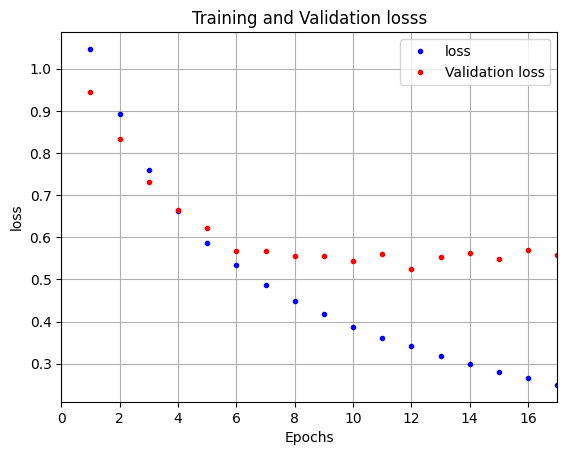

In [85]:
plot_training_history(history, monitor='loss')

In [87]:
test_scores = best_model.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], naive_baseline))
print('F1 Score (Test): {:.2f}'.format(test_scores[1]))
print('AUC (Test): {:.2f}'.format(test_scores[2]))

Accuracy (Test): 0.79 (Naive Baseline = 0.63)
F1 Score (Test): 0.74
AUC (Test): 0.91
